## Import Libraries

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from scipy.stats import gaussian_kde
from wordcloud import WordCloud, STOPWORDS

import re
import random
from spellchecker import SpellChecker  
from collections import Counter

## Initial Exploration

In [2]:
df = pd.read_csv('Emotion_classify_Data.csv')
df

,Comment,Emotion
0,i seriously hate one subject to death but now i feel reluctant to drop it,fear
1,im so full of life i feel appalled,anger
2,i sit here to write i start to dig out my feelings and i think that i am afraid to accept the possibility that he might not make it,fear
3,ive been really angry with r and i feel like an idiot for trusting him in the first place,joy
4,i feel suspicious if there is no one outside like the rapture has happened or something,fear
...,...,...
5932,i begun to feel distressed for you,fear
5933,i left feeling annoyed and angry thinking that i was the center of some stupid joke,anger
5934,i were to ever get married i d have everything ready to offer to him because i ve got it together and when i do go out to clubs even the perfect good looking guys feel intimated after talking to me about my clever self,joy
5935,i feel reluctant in applying there because i want to be able to find a company where i know at least one person,fear


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5937 entries, 0 to 5936
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Comment  5937 non-null   object
 1   Emotion  5937 non-null   object
dtypes: object(2)
memory usage: 92.9+ KB


In [4]:
df.describe()

,Comment,Emotion
count,5937,5937
unique,5934,3
top,i feel like a tortured artist when i talk to her,anger
freq,2,2000


In [5]:
df.isnull().sum() # 0 missing values

Comment    0
Emotion    0
dtype: int64

## Preprocessing

Check for words in sentences which does not exist in the dictionary.

In [6]:
# Load data
df = pd.read_csv("Emotion_classify_Data.csv" )

# Work on a copy so we keep original text untouched
df["Comment"] = df["Comment"].astype(str)


In [7]:
# HTML / URL noise removal

def remove_html_noise(text: str) -> str:
    # Remove HTML tags like <a ...>, <img ...>, <br>, etc.
    text = re.sub(r"<[^>]+>", " ", text)

    # Remove common HTML-ish tokens that appear as words
    text = re.sub(
        r"\b(?:href|src|img|class|rel|link|script|height|width|aligncenter|wp|http|https|www|css|meta|content)\b",
        " ",
        text,
        flags=re.IGNORECASE,
    )

    text = re.sub(r"http\S*", " ", text)

    return text

In [8]:
# RSS / FEED noise removal ( like encoding utf, locale en, isprivate false, atom xml, etc.)

RSS_NOISE_PATTERNS = [
    r"\bencoding\b",
    r"\blocale\b",
    r"\bisprivate\b",
    r"\bismobile\b",
    r"\bmobileclass\b",
    r"\bisprivateblog\b",
    r"\blanguagedirection\b",
    r"\bfeedlinks\b",
    r"\balternate\b",
    r"\bapplication\b",
    r"\batom\b",
    r"\bxml\b",
    r"\btype\b",
    r"\bfalse\b",
    r"\btrue\b",
    r"\btitle\b",
]

RSS_NOISE_REGEX = re.compile("|".join(RSS_NOISE_PATTERNS), flags=re.IGNORECASE)

def clean_rss_noise(text: str) -> str:
    return RSS_NOISE_REGEX.sub(" ", text)



In [9]:
CONTRACTION_MAP = [
    # --- Standard contractions ---
    (r"\blet's\b", "let us"),
    (r"\bwon't\b", "will not"),
    (r"\bcan't\b", "cannot"),
    (r"\bain't\b", "is not"),
    (r"\bdon't\b", "do not"),
    (r"\bdoesn't\b", "does not"),
    (r"\bdidn't\b", "did not"),
    (r"\bwouldn't\b", "would not"),
    (r"\bcouldn't\b", "could not"),
    (r"\bshouldn't\b", "should not"),
    (r"\bhaven't\b", "have not"),
    (r"\bhasn't\b", "has not"),
    (r"\bhadn't\b", "had not"),
    (r"\bi'm\b", "i am"),
    (r"\bhe's\b", "he is"),
    (r"\bshe's\b", "she is"),
    (r"\bit's\b", "it is"),

    # include both "that's" and broken "thats"
    (r"\bthat's\b", "that is"),
    (r"\bthats\b", "that is"),

    (r"\bwhat's\b", "what is"),
    (r"\bwhere's\b", "where is"),
    (r"\bthere's\b", "there is"),
    (r"\bwho's\b", "who is"),

    (r"\b're\b", " are"),
    (r"\b'd\b", " would"),
    (r"\b'll\b", " will"),
    (r"\b've\b", " have"),
    (r"\b'm\b", " am"),

    # --- Slang / informal ---
    (r"\bgonna\b", "going to"),
    (r"\bgotta\b", "got to"),
    (r"\bwanna\b", "want to"),
    (r"\blemme\b", "let me"),
    (r"\bgimme\b", "give me"),
    (r"\bkinda\b", "kind of"),
    (r"\bsorta\b", "sort of"),
    (r"\bcuz\b", "because"),
    (r"\bcause\b", "because"),
    (r"\bdunno\b", "do not know"),
    (r"\by'all\b", "you all"),
    (r"\bya\b", "you"),
    (r"\bu\b", "you"),
    (r"(?:(?<=\s)|^)r(?=\s)", "are"),  # 'r' as a word
    (r"\btho\b", "though"),
    (r"^'em\b", "them"),
    (r"\b'em\b", "them"),
    (r"\bem\b", "them"),

    # --- No-apostrophe / broken contractions (n't) ---
    (r"\bim\b", "i am"),
    (r"\bi m\b", "i am"),

    (r"\bive\b", "i have"),
    (r"\bi ve\b", "i have"),

    (r"\bdont\b", "do not"),
    (r"\bdon t\b", "do not"),

    (r"\bdoesnt\b", "does not"),
    (r"\bdoesn t\b", "does not"),

    (r"\bdidnt\b", "did not"),
    (r"\bdidn t\b", "did not"),

    (r"\bwasnt\b", "was not"),
    (r"\bwasn t\b", "was not"),

    (r"\bhavent\b", "have not"),
    (r"\bhaven t\b", "have not"),

    (r"\bhasnt\b", "has not"),
    (r"\bhasn t\b", "has not"),

    (r"\bhadnt\b", "had not"),
    (r"\bhadn t\b", "had not"),

    (r"\bshouldnt\b", "should not"),
    (r"\bshouldn t\b", "should not"),

    (r"\bcouldnt\b", "could not"),
    (r"\bcouldn t\b", "could not"),

    (r"\bwouldnt\b", "would not"),
    (r"\bwouldn t\b", "would not"),

    (r"\bisnt\b", "is not"),
    (r"\bisn t\b", "is not"),

    (r"\barent\b", "are not"),
    (r"\baren t\b", "are not"),

    (r"\byoure\b", "you are"),
    (r"\byou re\b", "you are"),

    (r"\btheyre\b", "they are"),
    (r"\bthey re\b", "they are"),

    (r"\btheres\b", "there is"),
    (r"\bthere s\b", "there is"),

    (r"\bweve\b", "we have"),
    (r"\bwe ve\b", "we have"),

    (r"\bisn\b", "is not"),
    (r"\bdoesn\b", "does not"),
    (r"\bhaven\b", "have not"),

    # --- Broken "ll" without apostrophe --
    (r"\bi ll\b", "i will"),
    (r"\byou ll\b", "you will"),
    (r"\bhe ll\b", "he will"),
    (r"\bshe ll\b", "she will"),
    (r"\bit ll\b", "it will"),
    (r"\bwe ll\b", "we will"),
    (r"\bthey ll\b", "they will"),
    (r"\bwho ll\b", "who will"),
    (r"\bthat ll\b", "that will"),
    (r"\bthere ll\b", "there will"),
    (r"\bhere ll\b", "here will"),

    # fallback: lone "ll" as a word → "will"
    (r"\bll\b", "will"),

    (r"\bfeelin\b", "feeling"),
]

def decontract(text: str) -> str:
    text = text.replace("’", "'").replace("‘", "'").replace("“", '"').replace("”", '"')
    text = text.lower()
    for pattern, repl in CONTRACTION_MAP:
        text = re.sub(pattern, repl, text)
    return text


In [10]:
def clean_comment(text: str) -> str:
    if not isinstance(text, str):
        text = str(text)

    #1: remove obvious HTML + URLs + html-ish tokens
    text = remove_html_noise(text)

    #2: remove RSS / feed garbage terms
    text = clean_rss_noise(text)

    #3: normalize contractions / slang
    text = decontract(text)

    #4: keep only letters, apostrophes, and spaces
    text = re.sub(r"[^a-z' ]+", " ", text)

    #5: collapse multiple spaces
    text = re.sub(r"\s+", " ", text).strip()

    return text

df["Comment_clean"] = df["Comment"].apply(clean_comment)


In [11]:
# Build vocab from cleaned text

tokens = []
for text in df["Comment_clean"]:
    tokens.extend(re.findall(r"[a-z']+", text))  # tokens of letters + apostrophes

freq = Counter(tokens)
vocab = list(freq.keys())

print(f"Unique tokens after cleaning: {len(vocab)}")


Unique tokens after cleaning: 8904


In [12]:
# Find unknown words

spell = SpellChecker(language="en")

unknown_words = spell.unknown(vocab)
print(f"Unknown words (raw): {len(unknown_words)}")


Unknown words (raw): 855


In [13]:
# Build suspicious words DataFrame

sus_rows = []
for w in unknown_words:
    sus_rows.append({
        "word": w,
        "count": freq[w],
        "suggestion": spell.correction(w),
    })

sus_df = pd.DataFrame(sus_rows)

sus_df = sus_df.sort_values(
    by=["count", "word"],
    ascending=[False, True]
).reset_index(drop=True)


In [14]:
# Add example index + example original comment (for easy checking)

example_indices = []
example_comments = []

for w in sus_df["word"]:
    mask = df["Comment_clean"].str.contains(rf"\b{re.escape(w)}\b", case=False, na=False)
    idx_matches = df[mask].index

    if len(idx_matches) > 0:
        idx0 = int(idx_matches[0])
        example_indices.append(idx0)
        # use original Comment for context
        example_comments.append(df.loc[idx0, "Comment"])
    else:
        example_indices.append(None)
        example_comments.append(None)

sus_df["example_index"] = example_indices
sus_df["example_comment"] = example_comments


In [15]:
# Export to CSV
output_path = "output_suspicious_words.csv"
sus_df.to_csv(output_path, index=False)
df.to_csv('cleaned_emotion_classify_data.csv')

sus_df.head(20)

,word,count,suggestion,example_index,example_comment
0,etc,19,et,179,i got a stitch in my side during the first mile couldnt feel my feet it was so cold etc etc
1,honoured,18,honored,341,i feel honoured that my clients walk through my doors sometimes for the very first time and trust me with their brand new one week old bundles of joy
2,lol,10,lot,353,i feel tat all of us in this world are clever just depending on how u are born if u are born to be errrr not good but it will still would have some good things that u have it just that u dun realise it lol i noe its quite lame hope no one have read it img src http shared
3,emo,7,ego,622,i cant explain how i truly feel but some words that encapsulate some of my me ness currently ecstatic happy bouncy relieved energised in a mood to dance wanting chocolate wanting to socialise right now smiley and about here i lose words that express but bah so emo
4,tv,7,to,1460,i feel so uptight about it because i know you hate it and are constantly trying to catch glimpses of the tv in the window and listen to it
5,haha,5,hah,868,i do occassionally miss wearing regular earrings but i feel like my plugs have just become such a vital part of who i am that probably sounds so silly and youre rolling your eyes at me now haha
6,pre,5,are,1346,im feeling very grumpy this week but its not just my annual outbreak of ptpt pre te pouhere tension there has surely been a great deal to be grumpy about this week
7,px,5,ex,1053,i will say that a little piece of me feels agitated when i watch discussions on race and there will i style color font family georgia serif font size px line height
8,realised,5,realized,2437,when i heard about the treatment of a friend in jail really inhuman i never realised that such things also happen in the netherlands
9,whos,5,who,596,i want to be recless but im feeling so uptight put your mamma in a headlock baby and do it right whooooos got the crack whooooooooos got the crack whooooo s got the crack whos got the craaaaaaack


In [16]:
sus_df

,word,count,suggestion,example_index,example_comment
0,etc,19,et,179,i got a stitch in my side during the first mile couldnt feel my feet it was so cold etc etc
1,honoured,18,honored,341,i feel honoured that my clients walk through my doors sometimes for the very first time and trust me with their brand new one week old bundles of joy
2,lol,10,lot,353,i feel tat all of us in this world are clever just depending on how u are born if u are born to be errrr not good but it will still would have some good things that u have it just that u dun realise it lol i noe its quite lame hope no one have read it img src http shared
3,emo,7,ego,622,i cant explain how i truly feel but some words that encapsulate some of my me ness currently ecstatic happy bouncy relieved energised in a mood to dance wanting chocolate wanting to socialise right now smiley and about here i lose words that express but bah so emo
4,tv,7,to,1460,i feel so uptight about it because i know you hate it and are constantly trying to catch glimpses of the tv in the window and listen to it
...,...,...,...,...,...
850,zhu,1,thu,4953,i men zhu said is snapbacks cheap i also feel here too dangerous at present for the sake of under the door of safety since see or leave this green lotus temple first wholesale obey snapback hats
851,zipline,1,airline,4770,i decided to try the zipline in picnic grove since we are feeling a bit of adventurous that day
852,zonisamide,1,None,3297,i have noticed improvement is in the gabapentin and last nights dose of zonisamide which left me feeling very relaxed
853,zq,1,q,3622,im feeling all kinds of conflicted about the bit with his rather violent reaction towards the paparazzi over that zq jcho cpine lunch


In [17]:
# checking
# target = "ll"

# mask = df["Comment_clean"].str.contains(rf"\b{re.escape(target)}\b", case=False, na=False)
# rows_with_ll = df.loc[mask, ["Comment", "Comment_clean"]]

# rows_with_ll


## EDA

In [18]:
df = pd.read_csv("cleaned_emotion_classify_data.csv")

### Basic dataset info

In [19]:
df.head()

,Unnamed: 0,Comment,Emotion,Comment_clean
0,0,i seriously hate one subject to death but now i feel reluctant to drop it,fear,i seriously hate one subject to death but now i feel reluctant to drop it
1,1,im so full of life i feel appalled,anger,i am so full of life i feel appalled
2,2,i sit here to write i start to dig out my feelings and i think that i am afraid to accept the possibility that he might not make it,fear,i sit here to write i start to dig out my feelings and i think that i am afraid to accept the possibility that he might not make it
3,3,ive been really angry with r and i feel like an idiot for trusting him in the first place,joy,i have been really angry with are and i feel like an idiot for trusting him in the first place
4,4,i feel suspicious if there is no one outside like the rapture has happened or something,fear,i feel suspicious if there is no one outside like the rapture has happened or something


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5937 entries, 0 to 5936
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Unnamed: 0     5937 non-null   int64 
 1   Comment        5937 non-null   object
 2   Emotion        5937 non-null   object
 3   Comment_clean  5937 non-null   object
dtypes: int64(1), object(3)
memory usage: 185.7+ KB


In [21]:
# drop uneccessary column
df = df.drop(columns=["Unnamed: 0"])

# fix data types
df["Comment"] = df["Comment"].astype(str)
df["Comment_clean"] = df["Comment_clean"].astype(str)
df["Emotion"] = df["Emotion"].astype("category")


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5937 entries, 0 to 5936
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Comment        5937 non-null   object  
 1   Emotion        5937 non-null   category
 2   Comment_clean  5937 non-null   object  
dtypes: category(1), object(2)
memory usage: 98.8+ KB


In [23]:
df.describe(include='all')

,Comment,Emotion,Comment_clean
count,5937,5937,5937
unique,5934,3,5934
top,i feel like a tortured artist when i talk to her,anger,i feel like a tortured artist when i talk to her
freq,2,2000,2


### Graphs

Emotion distribution

In [24]:
# color palette
emotions_palette = { 
    "light_grey": "#f1f1f1",         # background
    "pastel_grey_green": "#bad09f",
    "pastel_yellow": "#fef17f",      # joy
    "pastel_orange_1": "#ffd38f",
    "pastel_orange_2": "#ffa891",    # anger
    "pastel_purple": "#c9b6e7",      # fear
    "light_blue": "#b0c8ed",
    "dark_grey_brown": "#3a1e0c"     # text, spines, ticks
}

emotion_color_map = {
    "anger": emotions_palette["pastel_orange_2"],  
    "joy": emotions_palette["pastel_yellow"],      
    "fear": emotions_palette["pastel_purple"]      
}

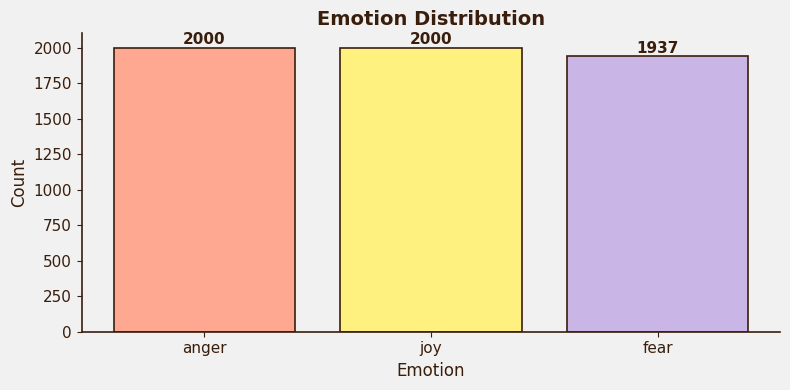

In [25]:
plt.style.use("default") 
fig, ax = plt.subplots(figsize=(8, 4))

# frequencies
emotion_counts = df['Emotion'].value_counts()

# Colors in same order as bar positions
bar_colors = [emotion_color_map[e] for e in emotion_counts.index]

# bg
fig.patch.set_facecolor(emotions_palette["light_grey"])
ax.set_facecolor(emotions_palette["light_grey"])

# Plot bars
bars = ax.bar(
    emotion_counts.index,
    emotion_counts.values,
    color=bar_colors,
    edgecolor=emotions_palette["dark_grey_brown"],
    linewidth=1.2
)

# Add count labels 
for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + 5,
        str(height),
        ha="center",
        va="bottom",
        fontsize=11,
        color=emotions_palette["dark_grey_brown"],
        fontweight="bold"
    )

# Axis style
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

for side in ["bottom", "left"]:
    ax.spines[side].set_color(emotions_palette["dark_grey_brown"])
    ax.spines[side].set_linewidth(1.2)

ax.tick_params(axis="both", colors=emotions_palette["dark_grey_brown"], labelsize=11)

# Labels and title
ax.set_title(
    "Emotion Distribution",
    fontsize=14,
    fontweight="bold",
    color=emotions_palette["dark_grey_brown"]
)

ax.set_xlabel("Emotion", fontsize=12, color=emotions_palette["dark_grey_brown"])
ax.set_ylabel("Count", fontsize=12, color=emotions_palette["dark_grey_brown"])

plt.tight_layout()
plt.show()

Sentence length distribution

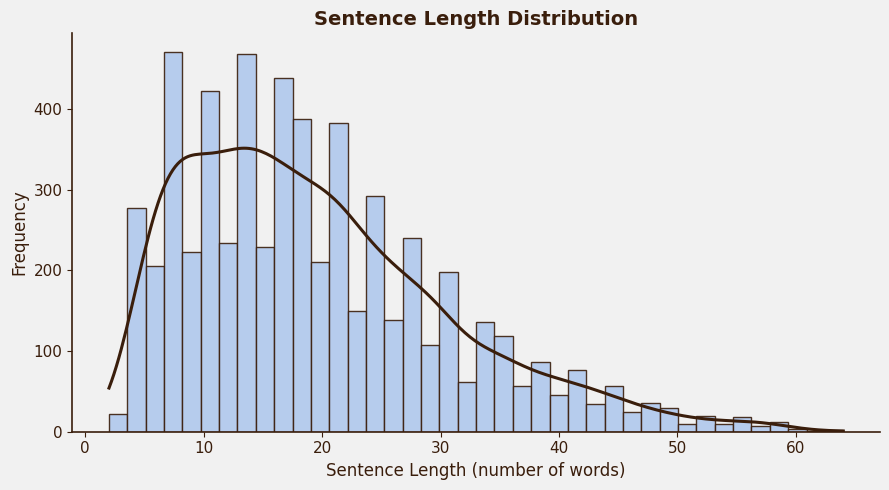

In [26]:
# Sentence length
df["sentence_length"] = df["Comment_clean"].str.split().str.len()
lengths = df["sentence_length"].dropna()
density = gaussian_kde(lengths)
xs = np.linspace(lengths.min(), lengths.max(), 300)
ys = density(xs)

fig, ax = plt.subplots(figsize=(9, 5))

# bg
fig.patch.set_facecolor(emotions_palette["light_grey"])
ax.set_facecolor(emotions_palette["light_grey"])

# histogram
ax.hist(
    lengths,
    bins=40,
    color=emotions_palette["light_blue"],
    edgecolor=emotions_palette["dark_grey_brown"],
    alpha=0.9
)

# KDE trend line
ax.plot(
    xs, ys * len(lengths) * (max(lengths)-min(lengths)) / 40,  # scale KDE to histogram
    color=emotions_palette["dark_grey_brown"],
    linewidth=2.2
)

ax.set_title(
    "Sentence Length Distribution",
    fontsize=14,
    fontweight="bold",
    color=emotions_palette["dark_grey_brown"]
)

ax.set_xlabel("Sentence Length (number of words)", fontsize=12, color=emotions_palette["dark_grey_brown"])
ax.set_ylabel("Frequency", fontsize=12, color=emotions_palette["dark_grey_brown"])

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
for side in ["bottom", "left"]:
    ax.spines[side].set_color(emotions_palette["dark_grey_brown"])
    ax.spines[side].set_linewidth(1.2)

ax.tick_params(axis="both", colors=emotions_palette["dark_grey_brown"], labelsize=11)
plt.tight_layout()
plt.show()


Most common words

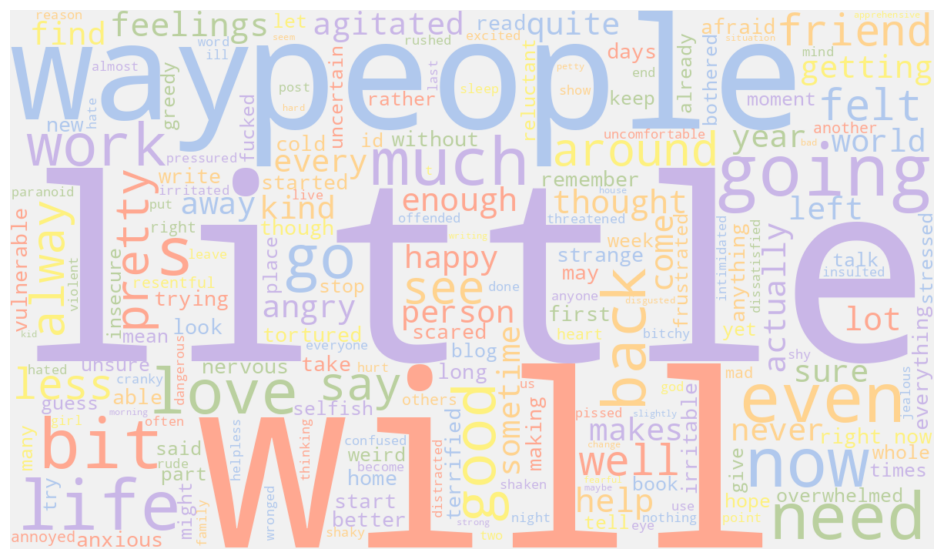

In [27]:
# Choose soft pastel colors for the cloud
wc_colors = [
    emotions_palette["pastel_yellow"],
    emotions_palette["pastel_orange_1"],
    emotions_palette["pastel_orange_2"],
    emotions_palette["pastel_purple"],
    emotions_palette["light_blue"],
    emotions_palette["pastel_grey_green"],
]

def pastel_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return random.choice(wc_colors)

text = " ".join(df["Comment_clean"].astype(str).tolist())

# ---- Stopwords ----
stopwords = set(STOPWORDS)
stopwords.update([
    # generic filler
    "feel", "feeling", "feels",
    "im", "ive", "dont", "didnt", "cant", "wont",
    "like", "just", "really", "also", "one", "get", "got",
    "thing", "things", "something", "someone",
    "know", "think", "want", "wanted", "make", "made",
    "day", "today", "time", "still",
])

wc = WordCloud(
    width=1200,
    height=700,
    background_color=emotions_palette["light_grey"],
    stopwords=stopwords,
    max_words=200,
    color_func=pastel_color_func,
).generate(text)

plt.figure(figsize=(12,7))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

Per-emotion text lengths

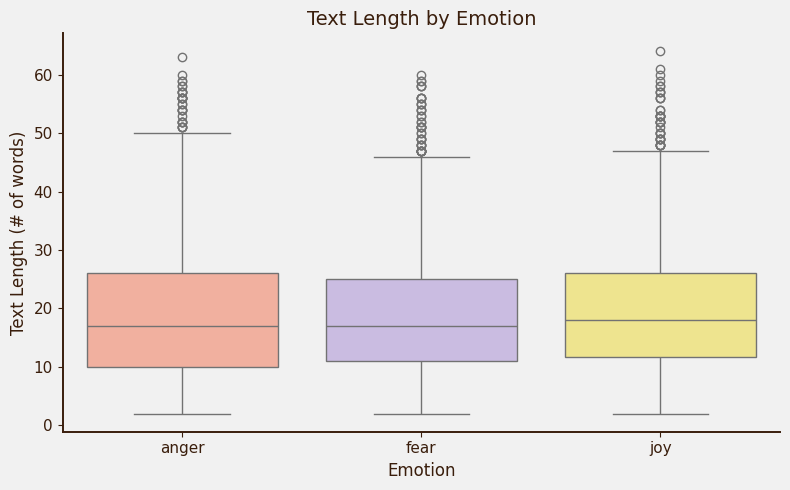

In [28]:
plt.figure(figsize=(8,5))
ax = sns.boxplot(
    data=df,
    x="Emotion",
    y="sentence_length",
    hue="Emotion",          # ← add this
    palette=emotion_color_map,
    legend=False            # ← hide redundant legend
)

ax.set_facecolor(emotions_palette["light_grey"])
plt.gcf().patch.set_facecolor(emotions_palette["light_grey"])

plt.title("Text Length by Emotion", fontsize=14, color=emotions_palette["dark_grey_brown"])
plt.xlabel("Emotion", fontsize=12, color=emotions_palette["dark_grey_brown"])
plt.ylabel("Text Length (# of words)", fontsize=12, color=emotions_palette["dark_grey_brown"])

for spine in ["bottom", "left"]:
    ax.spines[spine].set_color(emotions_palette["dark_grey_brown"])
    ax.spines[spine].set_linewidth(1.4)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.tick_params(colors=emotions_palette["dark_grey_brown"], labelsize=11)

plt.tight_layout()
plt.show()


Distribution of Comment Word Count by Emotion

C:\Users\osen\AppData\Local\Temp\ipykernel_21752\1165979462.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(


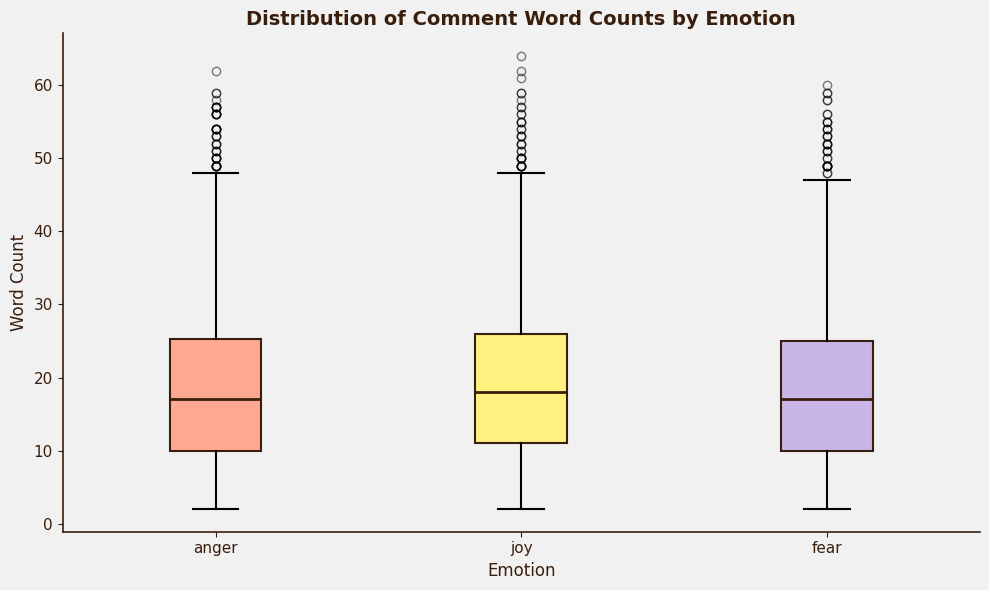

In [29]:
# Add word count column
df['word_count'] = df['Comment'].apply(lambda x: len(str(x).split()))

plt.style.use("default")
fig, ax = plt.subplots(figsize=(10, 6))

# Background colors
fig.patch.set_facecolor(emotions_palette["light_grey"])
ax.set_facecolor(emotions_palette["light_grey"])

# Plot boxplot with consistent colors by category
box = ax.boxplot(
    [df[df['Emotion'] == emotion]['word_count'] for emotion in emotion_color_map.keys()],
    patch_artist=True,
    labels=list(emotion_color_map.keys()),
    medianprops=dict(color=emotions_palette["dark_grey_brown"], linewidth=2),
    boxprops=dict(linewidth=1.5),
    whiskerprops=dict(linewidth=1.5),
    capprops=dict(linewidth=1.5),
    flierprops=dict(marker='o', color=emotions_palette["dark_grey_brown"], alpha=0.5)
)

# Color each box with the corresponding pastel color
for patch, emotion in zip(box['boxes'], emotion_color_map.keys()):
    patch.set_facecolor(emotion_color_map[emotion])
    patch.set_edgecolor(emotions_palette["dark_grey_brown"])

# Axis style tweaks
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
for side in ["bottom", "left"]:
    ax.spines[side].set_color(emotions_palette["dark_grey_brown"])
    ax.spines[side].set_linewidth(1.2)

ax.tick_params(axis="both", colors=emotions_palette["dark_grey_brown"], labelsize=11)

# Labels and title
ax.set_title(
    "Distribution of Comment Word Counts by Emotion",
    fontsize=14,
    fontweight="bold",
    color=emotions_palette["dark_grey_brown"]
)
ax.set_xlabel("Emotion", fontsize=12, color=emotions_palette["dark_grey_brown"])
ax.set_ylabel("Word Count", fontsize=12, color=emotions_palette["dark_grey_brown"])

plt.tight_layout()
plt.show()

Distribution of Comment Character Counts by Emotion

C:\Users\osen\AppData\Local\Temp\ipykernel_21752\1554741549.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(


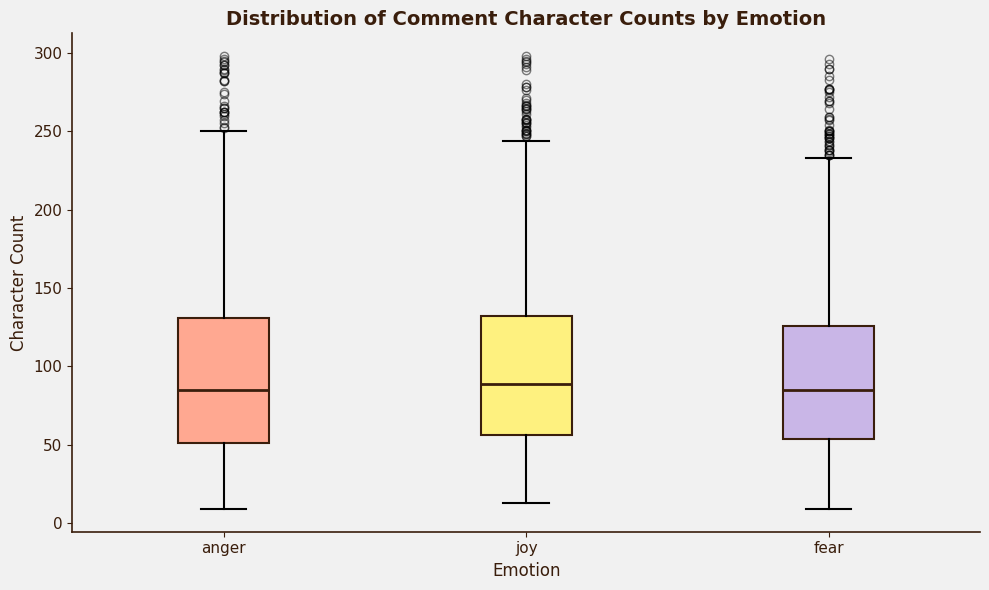

In [30]:
# Add char count column
df['char_count'] = df['Comment'].apply(len)

plt.style.use("default")
fig, ax = plt.subplots(figsize=(10, 6))

# Background colors
fig.patch.set_facecolor(emotions_palette["light_grey"])
ax.set_facecolor(emotions_palette["light_grey"])

# Plot boxplot with consistent colors by category
box = ax.boxplot(
    [df[df['Emotion'] == emotion]['char_count'] for emotion in emotion_color_map.keys()],
    patch_artist=True,
    labels=list(emotion_color_map.keys()),
    medianprops=dict(color=emotions_palette["dark_grey_brown"], linewidth=2),
    boxprops=dict(linewidth=1.5),
    whiskerprops=dict(linewidth=1.5),
    capprops=dict(linewidth=1.5),
    flierprops=dict(marker='o', color=emotions_palette["dark_grey_brown"], alpha=0.5)
)

# Color each box with the corresponding pastel color
for patch, emotion in zip(box['boxes'], emotion_color_map.keys()):
    patch.set_facecolor(emotion_color_map[emotion])
    patch.set_edgecolor(emotions_palette["dark_grey_brown"])

# Axis style tweaks
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
for side in ["bottom", "left"]:
    ax.spines[side].set_color(emotions_palette["dark_grey_brown"])
    ax.spines[side].set_linewidth(1.2)

ax.tick_params(axis="both", colors=emotions_palette["dark_grey_brown"], labelsize=11)

# Labels and title
ax.set_title(
    "Distribution of Comment Character Counts by Emotion",
    fontsize=14,
    fontweight="bold",
    color=emotions_palette["dark_grey_brown"]
)
ax.set_xlabel("Emotion", fontsize=12, color=emotions_palette["dark_grey_brown"])
ax.set_ylabel("Character Count", fontsize=12, color=emotions_palette["dark_grey_brown"])

plt.tight_layout()
plt.show()

Word Cloud per emotion

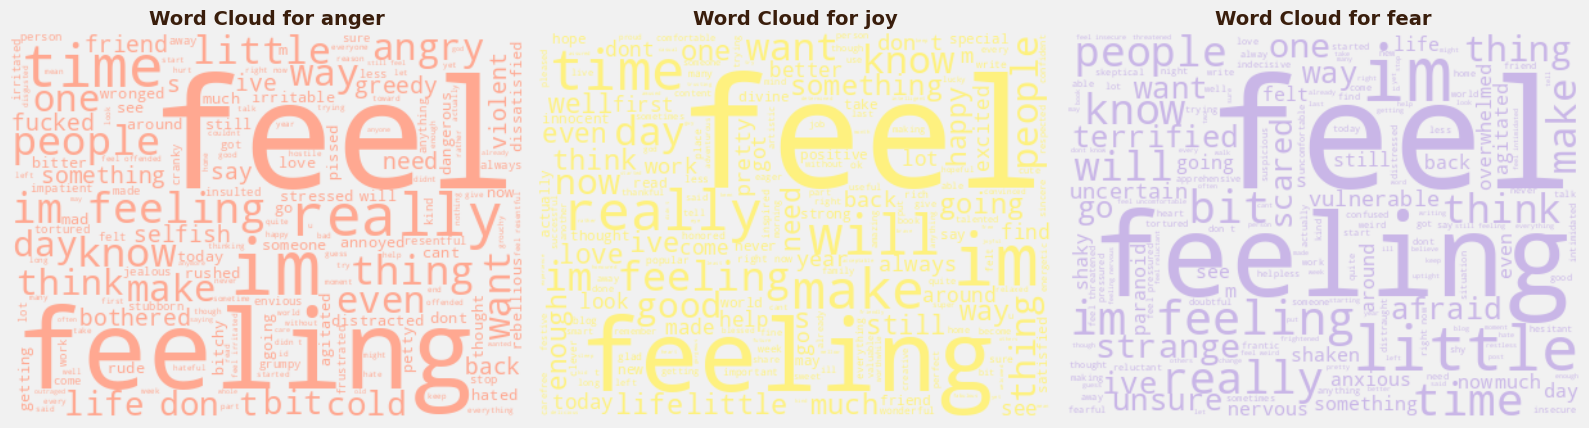

In [31]:
plt.style.use("default")
emotions = list(emotion_color_map.keys())

fig, axes = plt.subplots(1, len(emotions), figsize=(16, 6))
fig.patch.set_facecolor(emotions_palette["light_grey"])

for ax, emotion in zip(axes, emotions):
    text = " ".join(df[df['Emotion'] == emotion]['Comment'].astype(str).values)

    wordcloud = WordCloud(
        width=400,
        height=300,
        background_color=emotions_palette["light_grey"],
        colormap=None,
        color_func=lambda *args, **kwargs: emotion_color_map[emotion],
        contour_color=emotions_palette["dark_grey_brown"],
        contour_width=1.5,
        random_state=42
    ).generate(text)

    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(f'Word Cloud for {emotion}', fontsize=14, color=emotions_palette["dark_grey_brown"], fontweight="bold")

plt.tight_layout()
plt.show()